# Examine sample make-up

In [1]:
suppressMessages({library(SummarizedExperiment)
                  library(tidyverse)
                  library(ggpubr)})

## Samples after quality control

In [2]:
save_ggplots <- function(p, fn, w, h){
    for(ext in c('.pdf', '.svg')){
        ggsave(paste0(fn, ext), plot=p, width=w, height=h)
    }
}

### Load Caudate data

In [3]:
# Load counts and phenotype R variable
load("../../input/counts/_m/caudate_brainseq_phase3_hg38_rseGene_merged_n464.rda")
### Subset and recode
keepIndex = which((rse_gene$Dx %in% c('Control', "Schizo")) & 
                  rse_gene$Race %in% c('CAUC', 'AA'))
rse_gene = rse_gene[, keepIndex]
### Extract phenotypes
pheno_C <- colData(rse_gene) %>% as.data.frame

### Load DLPFC data

In [4]:
# Load counts and phenotype R variable
load("../../input/counts/_m/dlpfc_ribozero_brainseq_phase2_hg38_rseGene_merged_n453.rda")
### Subset and recode
keepIndex = which((rse_gene$Dx %in% c('Control', "Schizo")) & 
                  rse_gene$Race %in% c('CAUC', 'AA'))
rse_gene = rse_gene[, keepIndex]
### Extract phenotypes
pheno_D <- colData(rse_gene) %>% as.data.frame

### Load Hippocampus data

In [5]:
# Load counts and phenotype R variable
load("../../input/counts/_m/hippo_brainseq_phase2_hg38_rseGene_merged_n447.rda")
### Subset and recode
keepIndex = which((rse_gene$Dx %in% c('Control', "Schizo")) & 
                  rse_gene$Race %in% c('CAUC', 'AA'))
rse_gene = rse_gene[, keepIndex]
### Extract phenotypes
pheno_H <- colData(rse_gene) %>% as.data.frame

### Load DG data

In [6]:
# Load counts and phenotype R variable
load("../../input/counts/_m/astellas_dg_hg38_rseGene_n263.rda")
### Subset and recode
keepIndex = which((rse_gene$Dx %in% c('Control', "Schizo")) & 
                  rse_gene$Race %in% c('CAUC', 'AA'))
rse_gene = rse_gene[, keepIndex]
### Extract phenotypes
pheno_dg <- colData(rse_gene) %>% as.data.frame

### Merge data

In [7]:
allCols <- intersect(intersect(intersect(colnames(pheno_C), colnames(pheno_D)), 
                               colnames(pheno_H)), 
                     colnames(pheno_dg))
pheno = rbind(pheno_C[, allCols], pheno_D[, allCols], 
              pheno_H[, allCols], pheno_dg[, allCols]) %>% 
    filter(Age > 17) %>% mutate(Race=gsub("CAUC", "EA", Race))

## STRUCTURE analysis

In [8]:
ancestry = data.table::fread("../../input/ancestry_structure/structure.out_ancestry_proportion_raceDemo_compare")
ancestry %>% head(2)

id,Afr,Eur,group
<chr>,<dbl>,<dbl>,<chr>
Br2374,0.007,0.993,CAUC
Br1857,0.001,0.999,CAUC


In [9]:
ancestry %>% mutate_if(is.character, as.factor) %>%
    group_by(group) %>% summarize(AA=mean(Afr), EA=mean(Eur))

group,AA,EA
<fct>,<dbl>,<dbl>
AA,0.782219451,0.2177805
CAUC,0.007510536,0.9924895


In [10]:
ancestry %>% inner_join(pheno, by=c("id"="BrNum")) %>%
    filter(Age > 17, Dx == "Control") %>% select(group, Afr, Eur) %>% 
    mutate_if(is.character, as.factor) %>% distinct %>%
    group_by(group) %>% 
    summarize(AA_mean=mean(Afr), AA_sd=sd(Afr), AA_max=max(Afr), AA_min=min(Afr),
              EA_mean=mean(Eur), EA_sd=sd(Eur), EA_max=max(Eur), EA_min=min(Eur))

group,AA_mean,AA_sd,AA_max,AA_min,EA_mean,EA_sd,EA_max,EA_min
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AA,0.78962609,0.10611682,0.999,0.381,0.2103739,0.10611682,0.619,0.001
CAUC,0.03087879,0.02997578,0.156,0.001,0.9691212,0.02997578,0.999,0.844


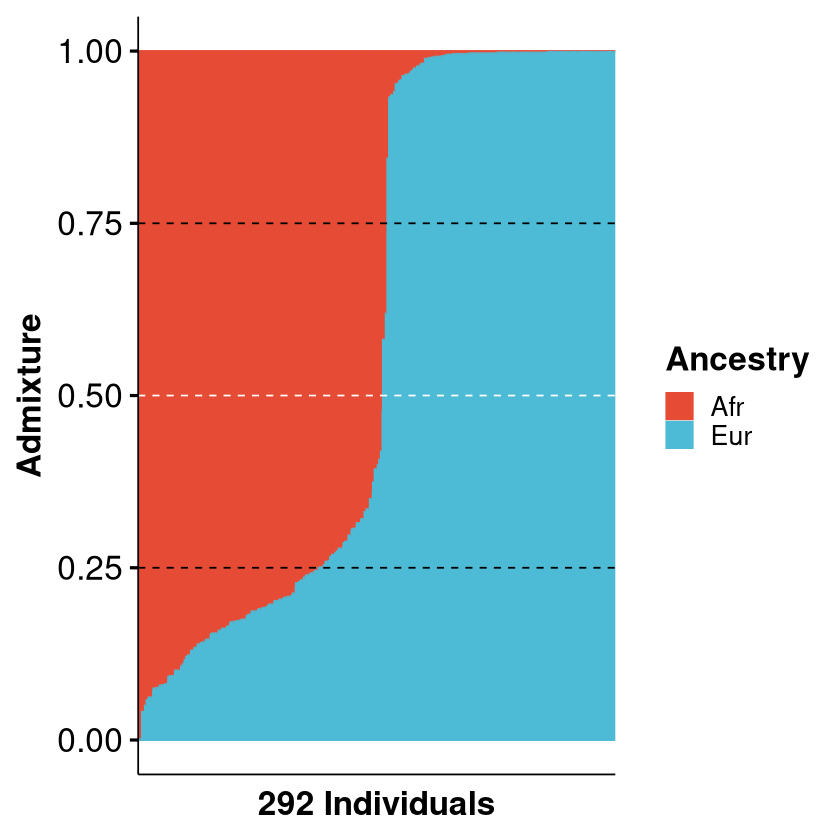

In [11]:
brp = ancestry %>% inner_join(pheno, by=c("id"="BrNum")) %>%
    filter(Age > 17, Dx == "Control") %>% select(id, Race, Afr, Eur) %>%
    mutate_if(is.character, as.factor) %>% distinct %>%
    pivot_longer(-c("Race", "id"), names_to="Ancestry", values_to="Proportion") %>% 
    mutate_if(is.character, as.factor) %>% group_by(Ancestry) %>% 
    mutate(ID = fct_reorder(id, desc(Proportion))) %>%
    ggbarplot(x="ID", y="Proportion", fill = "Ancestry", color="Ancestry",
              palette="npg", ylab="Admixture", xlab="292 Individuals", 
              ggtheme=theme_pubr(base_size=20), legend="right") +
    geom_hline(yintercept=0.5, linetype="dashed", color="white") +
    geom_hline(yintercept=0.75, linetype="dashed", color="black") +
    geom_hline(yintercept=0.25, linetype="dashed", color="black") +
    font("xy.title", face="bold") + font("legend.title", face="bold") +
    rremove("x.text") + rremove("x.ticks")
save_ggplots(brp, "ancestry_structure_barplot", 12, 5)
brp

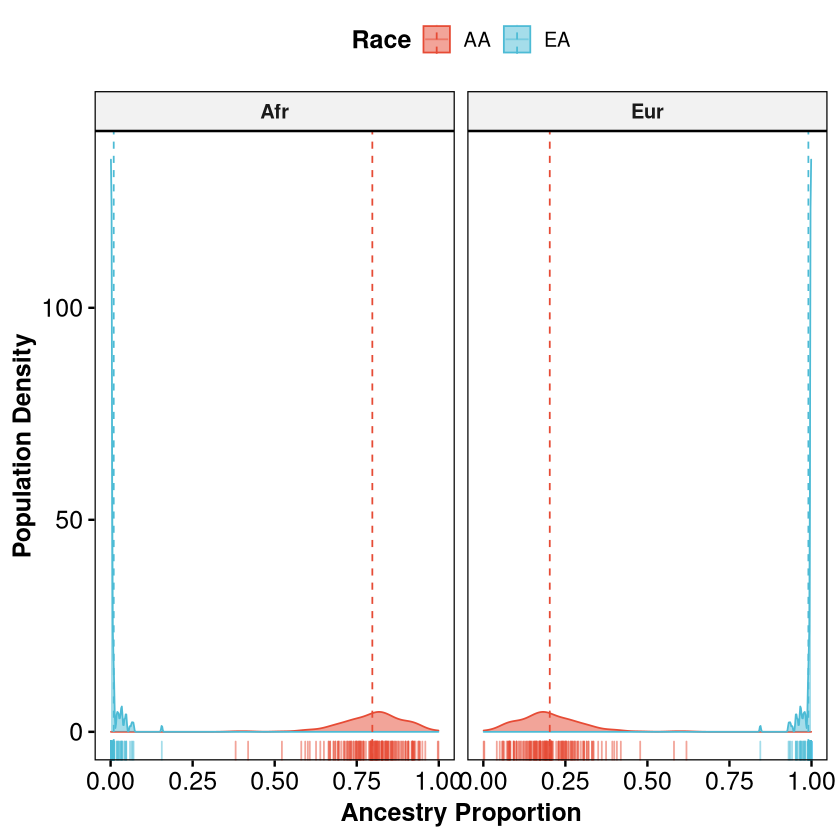

In [12]:
bxp = ancestry %>% inner_join(pheno, by=c("id"="BrNum")) %>%
    filter(Age > 17, Dx == "Control") %>% select(id, Race, Afr, Eur) %>%
    mutate_if(is.character, as.factor) %>% distinct %>%
    pivot_longer(-c("Race", "id"), names_to="Ancestry", values_to="Proportion") %>% 
    ggdensity(x="Proportion", color="Race", fill="Race", facet.by="Ancestry", 
              ncol=2, rug=TRUE, add="mean", palette="npg", ylab="Population Density", 
              xlab="Ancestry Proportion", panel.labs.font=list(face='bold'), 
              ggtheme=theme_pubr(base_size=15, border=TRUE)) + 
    font("xy.title", face="bold") + font("legend.title", face="bold")
save_ggplots(bxp, "ancestry_structure_distribution", 10, 5)
bxp

## eQTL analysis

In [13]:
pheno %>% dim

[1] 1291   21

In [14]:
print(paste("There are", unique(pheno$BrNum) %>% length, "unique BrNum."))

[1] "There are 485 unique BrNum."


In [15]:
pheno %>% select(BrNum, Region) %>% distinct %>%
    mutate_if(is.character, as.factor) %>% 
    group_by(Region) %>% count()

Region,n
<fct>,<int>
Caudate,394
DentateGyrus,161
DLPFC,360
HIPPO,376


In [16]:
pheno %>% select(BrNum, Race) %>% distinct %>%
    mutate_if(is.character, as.factor) %>% 
    group_by(Race) %>% count()

Race,n
<fct>,<int>
AA,249
EA,236


In [17]:
pheno %>% select(BrNum, Race, Region) %>% distinct %>%
    mutate_if(is.character, as.factor) %>% 
    group_by(Region, Race) %>% count()

Region,Race,n
<fct>,<fct>,<int>
Caudate,AA,205
Caudate,EA,189
DentateGyrus,AA,78
DentateGyrus,EA,83
DLPFC,AA,200
DLPFC,EA,160
HIPPO,AA,207
HIPPO,EA,169


In [18]:
pheno %>% select(BrNum, Sex, Region) %>% distinct %>%
    mutate_if(is.character, as.factor) %>% 
    group_by(Region, Sex) %>% count()

Region,Sex,n
<fct>,<fct>,<int>
Caudate,F,121
Caudate,M,273
DentateGyrus,F,48
DentateGyrus,M,113
DLPFC,F,114
DLPFC,M,246
HIPPO,F,121
HIPPO,M,255


In [19]:
pheno %>% group_by(Region) %>% 
  summarise_at(vars(c("Age")), list(mean = mean, sd = sd)) 

Region,mean,sd
<chr>,<dbl>,<dbl>
Caudate,49.65508,15.58123
DentateGyrus,50.06770,15.43849
DLPFC,47.36772,15.36858
HIPPO,47.03652,15.28105


In [20]:
pheno %>% group_by(Region, Race) %>% 
  summarise_at(vars(c("Age")), list(mean = mean, sd = sd)) 

Region,Race,mean,sd
<chr>,<chr>,<dbl>,<dbl>
Caudate,AA,48.98595,14.31824
Caudate,EA,50.38085,16.85304
DentateGyrus,AA,50.18423,15.53374
DentateGyrus,EA,49.95819,15.44210
DLPFC,AA,47.63338,14.77009
DLPFC,EA,47.03565,16.12621
HIPPO,AA,47.26860,14.84346
HIPPO,EA,46.75225,15.84035


In [21]:
pheno %>% filter(RIN != "NA") %>% mutate("RIN"=as.numeric(unlist(RIN))) %>% 
    group_by(Region) %>% summarise_at(vars(c("RIN")), list(mean = mean, sd = sd)) 

Region,mean,sd
<chr>,<dbl>,<dbl>
Caudate,7.860152,0.8665752
DentateGyrus,5.208403,1.1871187
DLPFC,7.667222,0.9209920
HIPPO,7.598138,1.0308426


In [22]:
pheno %>% filter(RIN != "NA") %>% mutate("RIN"=as.numeric(unlist(RIN))) %>% 
    group_by(Region, Race) %>% summarise_at(vars(c("RIN")), list(mean = mean, sd = sd)) 

Region,Race,mean,sd
<chr>,<chr>,<dbl>,<dbl>
Caudate,AA,7.860976,0.8435098
Caudate,EA,7.859259,0.8931664
DentateGyrus,AA,5.206349,1.2062837
DentateGyrus,EA,5.210714,1.1760765
DLPFC,AA,7.661500,0.9452169
DLPFC,EA,7.674375,0.8926849
HIPPO,AA,7.582126,1.0549556
HIPPO,EA,7.617751,1.0032885


### Pie chart

In [23]:
plot_pie <- function(tissue){
    pie = pheno %>% mutate_if(is.character, as.factor) %>% group_by(Region, Race) %>%
        count %>% as.data.frame %>% group_by(Region) %>%
        transmute(Race, Percent = round(n/sum(n)*100, 1)) %>%
        mutate(Labels=paste0(Race, " (", Percent, "%)")) %>% filter(Region == tissue) %>%
        ggpie("Percent", label="Labels", fill="Race", color="white", palette="npg", 
              lab.pos="in", lab.font=c(8, "bold", "white"),
              ggtheme=theme_pubr(base_size=20, legend="none"))
    return(pie)
}

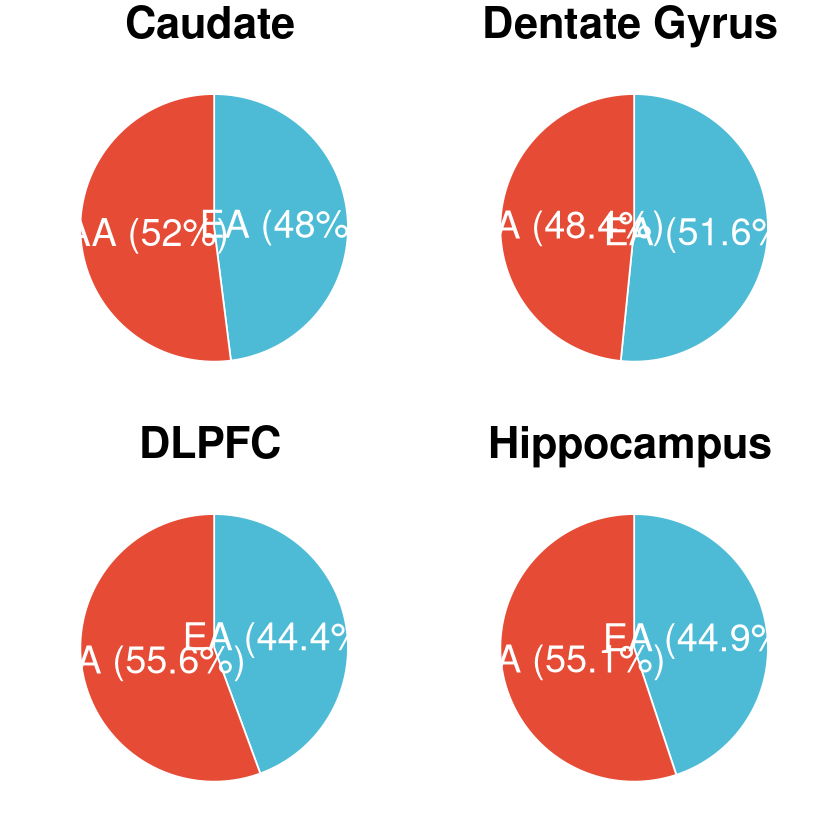

In [24]:
## Get and annotate plot
cc_pie = annotate_figure(plot_pie("Caudate"), 
                         top = text_grob("Caudate", face = "bold", size = 26))
gg_pie = annotate_figure(plot_pie("DentateGyrus"), 
                         top = text_grob("Dentate Gyrus", face = "bold", size = 26))
dd_pie = annotate_figure(plot_pie("DLPFC"), 
                         top = text_grob("DLPFC", face = "bold", size = 26))
hh_pie = annotate_figure(plot_pie("HIPPO"), 
                         top = text_grob("Hippocampus", face = "bold", size = 26))
## Arrange figure
figure <- ggarrange(cc_pie, gg_pie, dd_pie, hh_pie, ncol = 2, nrow = 2)
save_ggplots(figure, "ancestry_piecharts", 10, 10)
figure

## Adult individuals for expression related analysis

In [25]:
pheno = pheno %>% filter(Age > 17, Dx == "Control", Race == "AA")
pheno %>% dim

[1] 425  21

In [26]:
print(paste("There are", unique(pheno$BrNum) %>% length, "unique BrNum."))

[1] "There are 151 unique BrNum."


In [27]:
pheno %>% select(BrNum, Region) %>% distinct %>%
    mutate_if(is.character, as.factor) %>% 
    group_by(Region) %>% count()

Region,n
<fct>,<int>
Caudate,122
DentateGyrus,47
DLPFC,123
HIPPO,133


In [28]:
pheno %>% select(BrNum, Race) %>% distinct %>%
    mutate_if(is.character, as.factor) %>% 
    group_by(Race) %>% count()

Race,n
<fct>,<int>
AA,151


In [29]:
pheno %>% select(BrNum, Race, Region) %>% distinct %>%
    mutate_if(is.character, as.factor) %>% 
    group_by(Region, Race) %>% count()

Region,Race,n
<fct>,<fct>,<int>
Caudate,AA,122
DentateGyrus,AA,47
DLPFC,AA,123
HIPPO,AA,133


In [30]:
pheno %>% select(BrNum, Sex, Region) %>% distinct %>%
    mutate_if(is.character, as.factor) %>% 
    group_by(Region, Sex) %>% count()

Region,Sex,n
<fct>,<fct>,<int>
Caudate,F,50
Caudate,M,72
DentateGyrus,F,16
DentateGyrus,M,31
DLPFC,F,48
DLPFC,M,75
HIPPO,F,53
HIPPO,M,80


In [31]:
pheno %>% group_by(Region) %>% 
  summarise_at(vars(c("Age")), list(mean = mean, sd = sd)) 

Region,mean,sd
<chr>,<dbl>,<dbl>
Caudate,45.63770,14.72979
DentateGyrus,45.85043,16.32827
DLPFC,44.12511,14.97092
HIPPO,43.30015,14.73609


In [32]:
pheno %>% group_by(Region, Race) %>% 
  summarise_at(vars(c("Age")), list(mean = mean, sd = sd)) 

Region,Race,mean,sd
<chr>,<chr>,<dbl>,<dbl>
Caudate,AA,45.63770,14.72979
DentateGyrus,AA,45.85043,16.32827
DLPFC,AA,44.12511,14.97092
HIPPO,AA,43.30015,14.73609


In [33]:
pheno %>% filter(RIN != "NA") %>% mutate("RIN"=as.numeric(unlist(RIN))) %>% 
    group_by(Region) %>% summarise_at(vars(c("RIN")), list(mean = mean, sd = sd)) 

Region,mean,sd
<chr>,<dbl>,<dbl>
Caudate,7.829508,0.7993477
DentateGyrus,5.447368,1.2173824
DLPFC,7.696748,0.8851169
HIPPO,7.715038,0.9754173


In [34]:
pheno %>% filter(RIN != "NA") %>% mutate("RIN"=as.numeric(unlist(RIN))) %>% 
    group_by(Region, Race) %>% summarise_at(vars(c("RIN")), list(mean = mean, sd = sd)) 

Region,Race,mean,sd
<chr>,<chr>,<dbl>,<dbl>
Caudate,AA,7.829508,0.7993477
DentateGyrus,AA,5.447368,1.2173824
DLPFC,AA,7.696748,0.8851169
HIPPO,AA,7.715038,0.9754173


## Reproducibility Information

In [36]:
Sys.time()
proc.time()
options(width = 120)
sessioninfo::session_info()

[1] "2022-08-26 12:09:00 EDT"

    user   system  elapsed 
  31.643    1.333 1452.757 

,package,ondiskversion,loadedversion,path,loadedpath,attached,is_base,date,source,md5ok,library
,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<chr>,<chr>,<lgl>,<fct>
abind,abind,1.4.5,1.4-5,/home/kynon/R/x86_64-pc-linux-gnu-library/4.2/abind,/home/kynon/R/x86_64-pc-linux-gnu-library/4.2/abind,FALSE,FALSE,2016-07-21,CRAN (R 4.2.1),NA,/home/kynon/R/x86_64-pc-linux-gnu-library/4.2
assertthat,assertthat,0.2.1,0.2.1,/home/kynon/R/x86_64-pc-linux-gnu-library/4.2/assertthat,/home/kynon/R/x86_64-pc-linux-gnu-library/4.2/assertthat,FALSE,FALSE,2019-03-21,CRAN (R 4.2.1),NA,/home/kynon/R/x86_64-pc-linux-gnu-library/4.2
backports,backports,1.4.1,1.4.1,/home/kynon/R/x86_64-pc-linux-gnu-library/4.2/backports,/home/kynon/R/x86_64-pc-linux-gnu-library/4.2/backports,FALSE,FALSE,2021-12-13,CRAN (R 4.2.1),NA,/home/kynon/R/x86_64-pc-linux-gnu-library/4.2
base64enc,base64enc,0.1.3,0.1-3,/home/kynon/R/x86_64-pc-linux-gnu-library/4.2/base64enc,/home/kynon/R/x86_64-pc-linux-gnu-library/4.2/base64enc,FALSE,FALSE,2015-07-28,CRAN (R 4.2.0),NA,/home/kynon/R/x86_64-pc-linux-gnu-library/4.2
Biobase,Biobase,2.56.0,2.56.0,/home/kynon/R/x86_64-pc-linux-gnu-library/4.2/Biobase,/home/kynon/R/x86_64-pc-linux-gnu-library/4.2/Biobase,TRUE,FALSE,2022-04-26,Bioconductor,NA,/home/kynon/R/x86_64-pc-linux-gnu-library/4.2
BiocGenerics,BiocGenerics,0.42.0,0.42.0,/home/kynon/R/x86_64-pc-linux-gnu-library/4.2/BiocGenerics,/home/kynon/R/x86_64-pc-linux-gnu-library/4.2/BiocGenerics,TRUE,FALSE,2022-04-26,Bioconductor,NA,/home/kynon/R/x86_64-pc-linux-gnu-library/4.2
bitops,bitops,1.0.7,1.0-7,/home/kynon/R/x86_64-pc-linux-gnu-library/4.2/bitops,/home/kynon/R/x86_64-pc-linux-gnu-library/4.2/bitops,FALSE,FALSE,2021-04-24,CRAN (R 4.2.1),NA,/home/kynon/R/x86_64-pc-linux-gnu-library/4.2
broom,broom,1.0.0,1.0.0,/home/kynon/R/x86_64-pc-linux-gnu-library/4.2/broom,/home/kynon/R/x86_64-pc-linux-gnu-library/4.2/broom,FALSE,FALSE,2022-07-01,CRAN (R 4.2.1),NA,/home/kynon/R/x86_64-pc-linux-gnu-library/4.2
car,car,3.1.0,3.1-0,/home/kynon/R/x86_64-pc-linux-gnu-library/4.2/car,/home/kynon/R/x86_64-pc-linux-gnu-library/4.2/car,FALSE,FALSE,2022-06-15,CRAN (R 4.2.1),NA,/home/kynon/R/x86_64-pc-linux-gnu-library/4.2
